# Introduction to `linopy`

:::{note}
This material is in part adapted from the following resources:
- [Linopy Getting Started](https://linopy.readthedocs.io/en/latest/index.html)
- [PyPSA simple electricity market examples](https://pypsa.readthedocs.io/en/latest/examples/simple-electricity-market-examples.html)
:::

<img src="https://github.com/PyPSA/linopy/blob/master/doc/logo.png?raw=true" width="300px" />

[Linopy](https://linopy.readthedocs.io/en/latest/index.html)  is an open-source framework for formulating, solving, and analyzing optimization problems with Python.

With Linopy, you can create optimization models within Python that consist of decision variables, constraints, and optimization objectives. You can then solve these instances using a variety of commercial and open-source solvers (specialised software).

[Linopy](https://linopy.readthedocs.io/en/latest/index.html) supports a wide range of problem types, including:

- **Linear programming**
- Integer programming
- Mixed-integer programming
- Quadratic programming


:::{note}
Documentation for this package is available at https://linopy.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas linopy highspy
```
:::

## Solve a Basic Model

In this example, we explain the basic functions of the linopy `Model` class. First, we are setting up a very simple linear optimization model, given by

Minimize:
    $$x + 2y$$
subject to:
    $$ x \ge 0 $$
    $$y \ge 0 $$
    $$3x + 7y \ge 10 $$
    $$5x + 2y \ge 3 $$

### Initializing a `Model`

The Model class in Linopy is a fundamental part of the library. It serves as a container for all the relevant data associated with a linear optimization problem. This includes variables, constraints, and the objective function.

In [1]:
import linopy

m = linopy.Model()

This creates a new Model object, which you can then use to define your optimization problem.

:::{note}
It is good practice to choose a short variable name (like `m`) to reduce the verbosity of your code.
:::

### Adding decision variables

**Variables** are the unknowns of an optimisation problems and are intended to be given values by solving an optimisation problem. A variable can always be assigned with a lower and an upper bound. In our case, both `x` and `y` have a lower bound of zero (default is unbouded). In linopy, you can add variables to a `Model` using the `add_variables()` method:

In [2]:
x = m.add_variables(lower=0, name="x")
y = m.add_variables(lower=0, name="y");

`x` and `y` are linopy variables of the class `linopy.Variable`. Each of them contain all relevant information that define it. The `name` parameter is optional but can be useful for referencing the variables later.

In [3]:
x

Variable
--------
x ∈ [0, inf]

In [4]:
m.variables

linopy.model.Variables
----------------------
 * x
 * y

In [5]:
m.variables["x"]

Variable
--------
x ∈ [0, inf]

### Adding Constraints

**Constraints** are equality or inequality expressions that define the *feasible* space of the decision variables. They consist of the left hand side (LHS) and the right hand side (RHS). The first constraint that we want to write down is $3x + 7y = 10$ which we write out exactly in the mathematical way:

In [6]:
3 * x + 7 * y >= 10

Constraint (unassigned)
-----------------------
+3 x + 7 y ≥ 10.0

Note, we can also mix the constant and the variable expression, like this

In [7]:
3 * x + 7 * y - 10 >= 0

Constraint (unassigned)
-----------------------
+3 x + 7 y ≥ 10.0

… and linopy will automatically take over the separation of variables expression on the LHS, and constant values on the RHS.

The constraint is currently not assigned to the model. We assign it by calling the `add_constraints()` function:

In [8]:
m.add_constraints(3 * x + 7 * y >= 10)
m.add_constraints(5 * x + 2 * y >= 3);

In [9]:
m.constraints

linopy.model.Constraints
------------------------
 * con0
 * con1

In [10]:
m.constraints["con0"]

Constraint `con0`
-----------------
+3 x + 7 y ≥ 10.0

### Adding the Objective 

The objective function defines what you want to optimize. It is a function of variables that a solver attempts to maximize or minimize. You can set the objective function of a `linopy.Model` using the `add_objective()` method. For our example that would be

In [11]:
m.add_objective(x + 2 * y, sense="min")

In [12]:
m.objective

Objective:
----------
LinearExpression: +1 x + 2 y
Sense: min
Value: None

Note, we can either minimize or maximize in linopy. Per default, linopy applies `sense='min'` making it not necessary to explicitly define the optimization sense. In summary:

In [13]:
m

Linopy LP model

Variables:
----------
 * x
 * y

Constraints:
------------
 * con0
 * con1

Status:
-------
initialized

### Solving the Model

Once you've defined your `linopy.Model`  with variables, constraints, and an objective function, you can solve it using the `solve` method:

In [14]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 2 cols, 4 nonzeros
2 rows, 2 cols, 4 nonzeros
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 2(13) 0s
          2     2.8620689655e+00 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  2.8620689655e+00
HiGHS run time      :          0.00


('ok', 'optimal')

Solvers are needed to compute solutions to the optimization models. There exists a large variety of solvers. In many cases, they specialise in certain problem types or solving algorithms, e.g. linear or nonlinear problems.

- **open-source examples**: [CBC](https://www.coin-or.org/Cbc/), [GLPK](https://www.gnu.org/software/glpk/), [Ipopt](https://coin-or.github.io/Ipopt/), [HiGHS](https://highs.dev)
- **commercial examples**: [Gurobi](https://www.gurobi.com/), [CPLEX](https://www.ibm.com/de-de/analytics/cplex-optimizer), [FICO Xpress](https://www.fico.com/en/products/fico-xpress-optimization)

The open-source solvers are sufficient to handle meaningful linopy models with hundreds to several thousand variables and constraints. However, as applications get large or more complex, there may be a need to turn to a commercial solvers (which often provide free academic licenses).

For this course, we use HiGHS, which is already in the course environment `esm-2024`.

### Retrieving optimisation results

The solution of the linear problem is assigned to the variables under `solution` in form of a `xarray.Dataset`.

In [15]:
x.solution

<xarray.DataArray 'solution' ()> Size: 8B
array(0.03448276)

In [16]:
y.solution

<xarray.DataArray 'solution' ()> Size: 8B
array(1.4137931)

We can also read out the objective value:

In [17]:
m.objective.value

2.8620689655172415

And the dual values (or shadow prices) of the model's constraints: 

In [18]:
m.dual["con0"]

<xarray.DataArray 'con0' ()> Size: 8B
array(0.27586207)

Well done! You solved your first linopy model!

## Use Coordinates

Now, the real power of the package comes into play! 

Linopy is structured around the concept that variables, and therefore expressions and constraints, have coordinates. That is, a `Variable` object actually contains multiple variables across dimensions, just as we know it from a `numpy` array or a `pandas.DataFrame`.

Suppose the two variables `x` and `y` are now functions of time `t` and we would modify the problem according to: 

Minimize:
$$\sum_t x_t + 2 y_t$$

subject to:

$$x_t \ge 0 \qquad \forall t $$
$$y_t \ge 0 \qquad \forall t $$
$$3x_t + 7y_t \ge 10 t \qquad \forall t$$
$$5x_t + 2y_t \ge 3 t \qquad \forall t$$

whereas `t` spans all the range from 0 to 10.

In order to formulate the new problem with linopy, we start again by initializing a model.

In [19]:
m = linopy.Model()

Again, we define `x` and `y` using the `add_variables()` function, but now we are adding a `coords` argument. This automatically creates optimization variables for all coordinates, in this case time-steps `t`.

In [20]:
import pandas as pd

time = pd.Index(range(10), name="time")

x = m.add_variables(
    lower=0,
    coords=[time],
    name="x",
)
y = m.add_variables(lower=0, coords=[time], name="y")

In [21]:
x

Variable (time: 10)
-------------------
[0]: x[0] ∈ [0, inf]
[1]: x[1] ∈ [0, inf]
[2]: x[2] ∈ [0, inf]
[3]: x[3] ∈ [0, inf]
[4]: x[4] ∈ [0, inf]
[5]: x[5] ∈ [0, inf]
[6]: x[6] ∈ [0, inf]
[7]: x[7] ∈ [0, inf]
[8]: x[8] ∈ [0, inf]
[9]: x[9] ∈ [0, inf]

Following the previous example, we write the constraints out using the syntax from above, while multiplying the RHS with `t`. Note that the coordinates from the LHS and the RSH have to match. 

:::{note}
In the beginning, it is recommended to use explicit dimension names. In this way, things remain clear and no unexpected broadcasting (which we show later) will happen.
:::

In [22]:
factor = pd.Series(time, index=time)

3 * x + 7 * y >= 10 * factor

Constraint (unassigned) (time: 10):
-----------------------------------
[0]: +3 x[0] + 7 y[0] ≥ -0.0
[1]: +3 x[1] + 7 y[1] ≥ 10.0
[2]: +3 x[2] + 7 y[2] ≥ 20.0
[3]: +3 x[3] + 7 y[3] ≥ 30.0
[4]: +3 x[4] + 7 y[4] ≥ 40.0
[5]: +3 x[5] + 7 y[5] ≥ 50.0
[6]: +3 x[6] + 7 y[6] ≥ 60.0
[7]: +3 x[7] + 7 y[7] ≥ 70.0
[8]: +3 x[8] + 7 y[8] ≥ 80.0
[9]: +3 x[9] + 7 y[9] ≥ 90.0

It always helps to write out the constraints before adding them to the model. Since they look good, let's assign them.

In [23]:
con1 = m.add_constraints(3 * x + 7 * y >= 10 * factor, name="con1")
con2 = m.add_constraints(5 * x + 2 * y >= 3 * factor, name="con2")
m

Linopy LP model

Variables:
----------
 * x (time)
 * y (time)

Constraints:
------------
 * con1 (time)
 * con2 (time)

Status:
-------
initialized

Now, when it comes to the objective, we use the `sum` function of `linopy.LinearExpression`. This stacks all terms all terms of the `time` dimension and writes them into one big expression. 

In [24]:
obj = (x + 2 * y).sum()


In [25]:
obj

LinearExpression
----------------
+1 x[0] + 2 y[0] + 1 x[1] ... +2 y[8] + 1 x[9] + 2 y[9]

In [26]:
m.add_objective(obj, overwrite=True)

Then, we can solve:

In [27]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
18 rows, 18 cols, 36 nonzeros
18 rows, 18 cols, 36 nonzeros
Presolve : Reductions: rows 18(-2); columns 18(-2); elements 36(-4)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 18(585) 0s
         18     1.2879310345e+02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 18
Objective value     :  1.2879310345e+02
HiGHS run time      :          0.00


('ok', 'optimal')

In order to inspect the solution. You can go via the variables, i.e. `y.solution` or via the `solution` aggregator of the model, which combines the solution of all variables.

In [28]:
m.solution.to_dataframe()

,x,y
time,,
0,0.000000,0.000000
1,0.034483,1.413793
2,0.068966,2.827586
3,0.103448,4.241379
4,0.137931,5.655172
5,0.172414,7.068966
6,0.206897,8.482759
7,0.241379,9.896552
8,0.275862,11.310345


Sometimes it can be helpful to plot the solution:

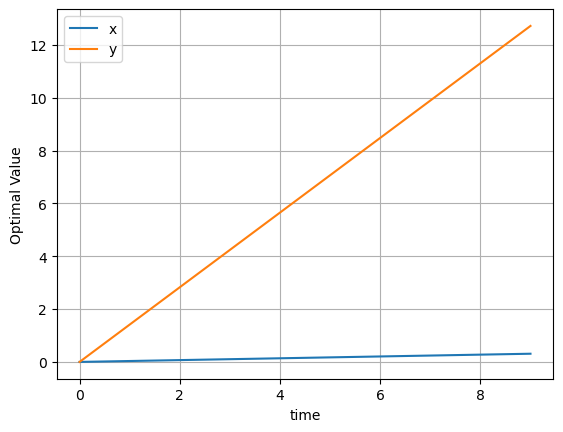

In [29]:
m.solution.to_dataframe().plot(grid=True, ylabel="Optimal Value");

Alright! Now you learned how to set up linopy variables and expressions with coordinates. For more advanced `linopy` operations you can check out the [User Guide](https://linopy.readthedocs.io/en/latest/user-guide.html).

## Electricity Market Examples

### Single bidding zone, single period

We want to minimise operational cost of an example electricity system representing South Africa subject to generator limits and meeting the load:

\begin{equation}
    \min_{g_s} \sum_s o_s g_s
  \end{equation}
  such that
  \begin{align}
    g_s &\leq G_s \\
    g_s &\geq 0 \\
    \sum_s g_s &= d
  \end{align}

We are given the following information on the South African electricity system:

Marginal costs in EUR/MWh

In [30]:
marginal_costs = pd.Series(
    [0, 30, 60, 80], index=["Wind", "Coal", "Gas", "Oil"]
)
marginal_costs

Wind     0
Coal    30
Gas     60
Oil     80
dtype: int64

Power plant capacities in MW

In [31]:
capacities = pd.Series(
    [3000, 35000, 8000, 2000], index=["Wind", "Coal", "Gas", "Oil"]
)
capacities

Wind     3000
Coal    35000
Gas      8000
Oil      2000
dtype: int64

Inelastic demand in MW

In [32]:
load = 42000

We now start building the model

In [33]:
m = linopy.Model()

Let's define the dispatch variables `g` with the `lower` and `upper` bound:
$$g_s \leq G_s $$
$$g_s \geq 0 $$

In [34]:
g = m.add_variables(
    lower=0, upper=capacities, coords=[capacities.index], name="g"
)
g

Variable (dim_0: 4)
-------------------
[Wind]: g[Wind] ∈ [0, 3000]
[Coal]: g[Coal] ∈ [0, 3.5e+04]
[Gas]: g[Gas] ∈ [0, 8000]
[Oil]: g[Oil] ∈ [0, 2000]

And and the objective to minimize total operational costs:
$$\min_{g_s} \sum_s o_s g_s$$

In [35]:
m.add_objective(marginal_costs.values * g, sense="min")
m.objective

Objective:
----------
LinearExpression: +0 g[Wind] + 30 g[Coal] + 60 g[Gas] + 80 g[Oil]
Sense: min
Value: None

Which is subject to: 

$$\sum_s g_s = d$$

In [36]:
m.add_constraints(g.sum() == load, name="energy_balance")

Constraint `energy_balance`
---------------------------
+1 g[Wind] + 1 g[Coal] + 1 g[Gas] + 1 g[Oil] = 42000.0

Then, we can solve the model:

In [37]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1 rows, 3 cols, 3 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-1); columns 0(-4); elements 0(-4) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.2900000000e+06
HiGHS run time      :          0.00


('ok', 'optimal')

This is the optimimal generator dispatch (MW)

In [38]:
m.solution.to_dataframe()

,g
dim_0,
Wind,3000.0
Coal,35000.0
Gas,4000.0
Oil,0.0


And the market clearing price we can read from the shadow price of the energy balance constraint (i.e. the added cost of increasing electricity demand by one unit):

In [39]:
m.dual["energy_balance"]

<xarray.DataArray 'energy_balance' ()> Size: 8B
array(60.)

### Two bidding zones with transmission

Let's add a spatial dimension, such that the optimisation problem is expanded to
\begin{equation}
  \min_{g_{i,s}, f_\ell} \sum_s o_{i,s} g_{i,s}
\end{equation}
such that
\begin{align}
  g_{i,s} &\leq G_{i,s} \\
  g_{i,s} &\geq 0 \\
  \sum_s g_{i,s} - \sum_\ell K_{i\ell} f_\ell &= d_i & \text{KCL} \\
  |f_\ell| &\leq F_\ell & \text{line limits}  \\
  \sum_\ell C_{\ell c} x_\ell f_\ell &= 0 & \text{KVL} 
\end{align}

In this example, we connect the previous South African electricity system with a hydro generation unit in Mozambique through a single transmission line. Note that because a single transmission line will not result in any cycles, we can neglect KVL in this case.

We are given the following data (all in MW):

In [40]:
generators = ["Coal", "Wind", "Gas", "Oil", "Hydro"]
countries = ["South_Africa", "Mozambique"]

In [41]:
capacities = pd.DataFrame(
    {
        "Coal": [35000, 0],
        "Wind": [3000, 0],
        "Gas": [8000, 0],
        "Oil": [2000, 0],
        "Hydro": [0, 1200],
    },
    index=countries,
)
capacities.index.name = "countries"
capacities.columns.name = "generators"

capacities

generators,Coal,Wind,Gas,Oil,Hydro
countries,,,,,
South_Africa,35000,3000,8000,2000,0
Mozambique,0,0,0,0,1200


In [42]:
# variable costs in EUR/MWh
marginal_costs = pd.Series([30, 0, 60, 80, 0], index=generators)
marginal_costs.index.name = "generators"
marginal_costs

generators
Coal     30
Wind      0
Gas      60
Oil      80
Hydro     0
dtype: int64

In [43]:
load = pd.Series([42000, 650], index=countries)
load.index.name = "countries"
load

countries
South_Africa    42000
Mozambique        650
dtype: int64

In [44]:
transmission = 500

Let's start with a new model instance

In [45]:
m = linopy.Model()

Now we create dispatch variables, as before, with the `upper` and `lower` bound for each countries and generators.

In [46]:
capacities

generators,Coal,Wind,Gas,Oil,Hydro
countries,,,,,
South_Africa,35000,3000,8000,2000,0
Mozambique,0,0,0,0,1200


In [47]:
g = m.add_variables(lower=0, upper=capacities, name="g")
g

Variable (countries: 2, generators: 5)
--------------------------------------
[South_Africa, Coal]: g[South_Africa, Coal] ∈ [0, 3.5e+04]
[South_Africa, Wind]: g[South_Africa, Wind] ∈ [0, 3000]
[South_Africa, Gas]: g[South_Africa, Gas] ∈ [0, 8000]
[South_Africa, Oil]: g[South_Africa, Oil] ∈ [0, 2000]
[South_Africa, Hydro]: g[South_Africa, Hydro] ∈ [0, 0]
[Mozambique, Coal]: g[Mozambique, Coal] ∈ [0, 0]
[Mozambique, Wind]: g[Mozambique, Wind] ∈ [0, 0]
[Mozambique, Gas]: g[Mozambique, Gas] ∈ [0, 0]
[Mozambique, Oil]: g[Mozambique, Oil] ∈ [0, 0]
[Mozambique, Hydro]: g[Mozambique, Hydro] ∈ [0, 1200]

We now define the line limit for the transmission line, assuming that power flowing from Mozambique	to South Africa is positive.

The line limit equation can be defined as   
\begin{align}
|f_\ell| &\leq F_\ell & \text{line limits}
\end{align}

In [48]:
f = m.add_variables(lower=-transmission, upper=transmission, name="flow_MZ_SA")
f

Variable
--------
flow_MZ_SA ∈ [-500, 500]

The energy balance constraint is replaced by KCL, where we take into account local generation as well as incoming or outgoing flows. The KCL equation can be defined as:
\begin{align}
  \sum_s g_{i,s} - \sum_\ell K_{i\ell} f_\ell &= d_i & \text{KCL} \\
\end{align}

We also need the incidence matrix $K_{i\ell}$ of this network (here it's very simple!) and assume some direction for the flow variable. Here, we picked the orientation from South Africa to Mozambique. This means that if the values for the flow variable $f_\ell$ are positive South Africa exports to Mozambique and vice versa if the variable takes negative values.

In [49]:
for country in countries:
    sign = -1 if country == "Mozambique" else 1  # minimal incidence matrix
    m.add_constraints(
        g.loc[country].sum() + sign * f == load[country],
        name=f"{country}_KCL",
    )

In [50]:
m.constraints["Mozambique_KCL"]

Constraint `Mozambique_KCL`
---------------------------
+1 g[Mozambique, Coal] + 1 g[Mozambique, Wind] + 1 g[Mozambique, Gas] + 1 g[Mozambique, Oil] + 1 g[Mozambique, Hydro] - 1 flow_MZ_SA = 650.0

The objective can be written as:
$$\min_{g_{i,s}, f_\ell} \sum_s o_{i,s} g_{i,s}$$

In [51]:
obj = (g * marginal_costs).sum()
obj

LinearExpression
----------------
+30 g[South_Africa, Coal] + 30 g[Mozambique, Coal] + 0 g[South_Africa, Wind] ... +80 g[Mozambique, Oil] + 0 g[South_Africa, Hydro] + 0 g[Mozambique, Hydro]

In [52]:
m.add_objective(obj, sense="min")

We now solve the model.

In [53]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1 rows, 4 cols, 4 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-2); columns 0(-11); elements 0(-12) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.2600000000e+06
HiGHS run time      :          0.00


('ok', 'optimal')

Now, we print the optimization results

In [54]:
m.objective.value

1260000.0

In [55]:
g.solution.to_dataframe()

solution
countries    generators          
South_Africa Coal         35000.0
             Wind          3000.0
             Gas           3500.0
             Oil              0.0
             Hydro            0.0
Mozambique   Coal             0.0
             Wind             0.0
             Gas              0.0
             Oil              0.0
             Hydro         1150.0

In [57]:
m.constraints["South_Africa_KCL"].dual

<xarray.DataArray 'dual' ()> Size: 8B
array(60.)
Coordinates:
    countries  <U12 48B 'South_Africa'

In [58]:
m.constraints["Mozambique_KCL"].dual

<xarray.DataArray 'dual' ()> Size: 8B
array(-0.)
Coordinates:
    countries  <U10 40B 'Mozambique'

### Single bidding zone with several periods

In this example, we consider multiple time periods (labelled [0,1,2,3]) to represent variable wind generation and changing load.

\begin{equation}
  \min_{g_{s,t}} \sum_s o_{s} g_{s,t}
\end{equation}
such that
\begin{align}
  g_{s,t} &\leq \hat{g}_{s,t} G_{i,s} \\
  g_{s,t} &\geq 0 \\
  \sum_s g_{s,t} &= d_t
\end{align}

We are given the following data as before, just dropiing Mozambique:

In [59]:
capacities = capacities.loc["South_Africa"]

In [60]:
time_index = pd.Index([0,1,2,3], name="time")
time_index

Index([0, 1, 2, 3], dtype='int64', name='time')

In [61]:
capacity_factors = pd.DataFrame(
    {
        "Coal": 4*[1],
        "Wind": [0.3, 0.6, 0.4, 0.5],
        "Gas": 4*[1],
        "Oil": 4*[1],
        "Hydro": 4*[1],
    },
    index=time_index,
    columns=generators,
)
capacity_factors.index.name = "time"
capacity_factors.columns.name = "generators"
capacity_factors

generators,Coal,Wind,Gas,Oil,Hydro
time,,,,,
0,1,0.3,1,1,1
1,1,0.6,1,1,1
2,1,0.4,1,1,1
3,1,0.5,1,1,1


In [62]:
load = pd.Series(
    [42000, 43000, 45000, 46000], index=time_index
)
load.index.name = "time"

We now start building the model:

In [63]:
m = linopy.Model()

Let's define the dispatch variables `g` with the `lower` and `upper` bound:
  \begin{align}
    g_{s,t} &\leq \hat{g}_{s,t} G_{i,s} \\
    g_{s,t} &\geq 0 \\
  \end{align}

In [64]:
g = m.add_variables(
    lower=0, upper=capacities * capacity_factors, name="g"
)
g

Variable (time: 4, generators: 5)
---------------------------------
[0, Coal]: g[0, Coal] ∈ [0, 3.5e+04]
[0, Wind]: g[0, Wind] ∈ [0, 900]
[0, Gas]: g[0, Gas] ∈ [0, 8000]
[0, Oil]: g[0, Oil] ∈ [0, 2000]
[0, Hydro]: g[0, Hydro] ∈ [0, 0]
[1, Coal]: g[1, Coal] ∈ [0, 3.5e+04]
[1, Wind]: g[1, Wind] ∈ [0, 1800]
		...
[2, Oil]: g[2, Oil] ∈ [0, 2000]
[2, Hydro]: g[2, Hydro] ∈ [0, 0]
[3, Coal]: g[3, Coal] ∈ [0, 3.5e+04]
[3, Wind]: g[3, Wind] ∈ [0, 1500]
[3, Gas]: g[3, Gas] ∈ [0, 8000]
[3, Oil]: g[3, Oil] ∈ [0, 2000]
[3, Hydro]: g[3, Hydro] ∈ [0, 0]

Then, we add the objective:
\begin{equation}
  \min_{g_{s,t}} \sum_s o_{s} g_{s,t}
\end{equation}

In [65]:
m.add_objective((g * marginal_costs).sum(), sense="min")
m.objective

Objective:
----------
LinearExpression: +30 g[0, Coal] + 30 g[1, Coal] + 30 g[2, Coal] ... +0 g[1, Hydro] + 0 g[2, Hydro] + 0 g[3, Hydro]
Sense: min
Value: None

Which is subject to:
\begin{align}
  \sum_s g_{s,t} &= d_t
\end{align}

In [66]:
m.add_constraints(
    g.sum("generators") == load,
    name="energy_balance",
)

Constraint `energy_balance` (time: 4):
--------------------------------------
[0]: +1 g[0, Coal] + 1 g[0, Wind] + 1 g[0, Gas] + 1 g[0, Oil] + 1 g[0, Hydro] = 42000.0
[1]: +1 g[1, Coal] + 1 g[1, Wind] + 1 g[1, Gas] + 1 g[1, Oil] + 1 g[1, Hydro] = 43000.0
[2]: +1 g[2, Coal] + 1 g[2, Wind] + 1 g[2, Gas] + 1 g[2, Oil] + 1 g[2, Hydro] = 45000.0
[3]: +1 g[3, Coal] + 1 g[3, Wind] + 1 g[3, Gas] + 1 g[3, Oil] + 1 g[3, Hydro] = 46000.0

We now solve the model:

In [67]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
4 rows, 12 cols, 12 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-4); columns 0(-20); elements 0(-20) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.0820000000e+06
HiGHS run time      :          0.00


('ok', 'optimal')

We display the results. For ease of reading, we round the results to 2 decimals:

In [68]:
m.objective.value

6082000.0

In [69]:
g.solution.round(2).to_dataframe().squeeze().unstack()

generators,Coal,Wind,Gas,Oil,Hydro
time,,,,,
0,35000.0,900.0,6100.0,0.0,0.0
1,35000.0,1800.0,6200.0,0.0,0.0
2,35000.0,1200.0,8000.0,800.0,0.0
3,35000.0,1500.0,8000.0,1500.0,0.0


In [70]:
m.dual.to_dataframe()

,energy_balance
time,
0,60.0
1,60.0
2,80.0
3,80.0


### Single bidding zone with several periods and storage

Now, we want to expand the optimisation model with a storage unit to do price arbitrage to reduce oil consumption.

We have been given the following characteristics of the storage:

In [71]:
storage_energy = 6000  # MWh
storage_power = 1000  # MW
efficiency = 0.9  # discharge = charge
standing_loss = 0.00001  # per hour

In [72]:
m

Linopy LP model

Variables:
----------
 * g (time, generators)

Constraints:
------------
 * energy_balance (time)

Status:
-------
ok

To model a storage unit, we need three additional variables for the discharging and charging of the storage unit and for its state of charge (energy filling level). We can directly define the bounds of these variables in the variable definition:

In [73]:
battery_discharge = m.add_variables(
    lower=0, upper=storage_power, coords=[time_index], name="battery_discharge"
)
battery_charge = m.add_variables(
    lower=0, upper=storage_power, coords=[time_index], name="battery_charge"
)
battery_soc = m.add_variables(
    lower=0, upper=storage_energy, coords=[time_index], name="battery_soc"
)

Then, we implement the storage consistency equations,

$$e_{t} = (1-\text{standing loss}) \cdot e_{t-1} + \eta \cdot g_{charge, t} - \frac{1}{\eta} \cdot g_{discharge, t}$$

For the initial period, we set the state of charge to zero.

$$e_{0} = 0$$

In [74]:
m.add_constraints(battery_soc.loc[0] == 0, name="soc_initial")

Constraint `soc_initial`
------------------------
+1 battery_soc[0] = -0.0

In [75]:
m.add_constraints(
    battery_soc.loc[1:] == (1 - standing_loss) * battery_soc.shift(time=1).loc[1:] + efficiency * battery_charge.loc[1:] - 1 / efficiency * battery_discharge.loc[1:],
    name="soc_consistency",
)

Constraint `soc_consistency` (time: 3):
---------------------------------------
[1]: +1 battery_soc[1] - 1 battery_soc[0] - 0.9 battery_charge[1] + 1.111 battery_discharge[1] = -0.0
[2]: +1 battery_soc[2] - 1 battery_soc[1] - 0.9 battery_charge[2] + 1.111 battery_discharge[2] = -0.0
[3]: +1 battery_soc[3] - 1 battery_soc[2] - 0.9 battery_charge[3] + 1.111 battery_discharge[3] = -0.0

And we also need to modify the energy balance to include the contributions of storage discharging and charging.

For that, we should first remove the existing energy balance constraint, which we seek to overwrite.

In [76]:
m.remove_constraints("energy_balance")

In [77]:
m.add_constraints(
    g.sum("generators") + battery_discharge - battery_charge == load,
    name="energy_balance",
)

Constraint `energy_balance` (time: 4):
--------------------------------------
[0]: +1 g[0, Coal] + 1 g[0, Wind] + 1 g[0, Gas] ... +1 g[0, Hydro] + 1 battery_discharge[0] - 1 battery_charge[0] = 42000.0
[1]: +1 g[1, Coal] + 1 g[1, Wind] + 1 g[1, Gas] ... +1 g[1, Hydro] + 1 battery_discharge[1] - 1 battery_charge[1] = 43000.0
[2]: +1 g[2, Coal] + 1 g[2, Wind] + 1 g[2, Gas] ... +1 g[2, Hydro] + 1 battery_discharge[2] - 1 battery_charge[2] = 45000.0
[3]: +1 g[3, Coal] + 1 g[3, Wind] + 1 g[3, Gas] ... +1 g[3, Hydro] + 1 battery_discharge[3] - 1 battery_charge[3] = 46000.0

We now solve the model:

In [78]:
m.solve()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d-dirty]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
7 rows, 21 cols, 29 nonzeros
4 rows, 10 cols, 15 nonzeros
Presolve : Reductions: rows 4(-4); columns 10(-22); elements 15(-26)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     5.3580000000e+06 Pr: 2(10300) 0s
          7     6.0172006560e+06 Pr: 0(0) 0s
          7     6.0172006560e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  6.0172006560e+06
HiGHS run time      :          0.00


('ok', 'optimal')

We display the results:

In [79]:
m.objective.value

6017200.655993455

In [80]:
g.solution.to_dataframe().squeeze().unstack()

generators,Coal,Wind,Gas,Oil,Hydro
time,,,,,
0,35000.0,900.0,5100.0,0.0000,0.0
1,35000.0,1800.0,7200.0,0.0000,0.0
2,35000.0,1200.0,8000.0,0.0000,0.0
3,35000.0,1500.0,8000.0,1490.0082,0.0


In [81]:
battery_discharge.solution.to_dataframe()

,solution
time,
0,1000.0000
1,0.0000
2,800.0000
3,9.9918


In [82]:
battery_charge.solution.to_dataframe()

,solution
time,
0,0.0
1,1000.0
2,0.0
3,0.0


In [83]:
battery_soc.solution.to_dataframe()

,solution
time,
0,-0.000000
1,900.000000
2,11.102111
3,0.000000


### Exercise

- Using the conversion efficiencies and specific emissions from the lecture slides, add a constraint that limits the total emissions in the four periods to 50% of the unconstrained optimal solution. How does the optimal objective value and the generator dispatch change?

- Reimplement the storage consistency constraint such that the initial state of charge is not zero but corresponds to the state of charge in the final period of the optimisation horizon.

- What parameters of the storage unit would have to be changed to reduce the objective? What's the sensitivity?